In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, LSTM, SimpleRNN, Dropout, Reshape
from tensorflow.keras.utils import to_categorical

import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries

import warnings
warnings.filterwarnings('ignore')


In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
DATASET_PATH = r'C:\Users\amity\Downloads\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset'

In [4]:
IMG_SIZE = 128

# Define categories
categories = ['Normal cases', 'Bengin cases', 'Malignant cases']

In [5]:
def load_data(dataset_path):
    images, labels = [], []
    print("Loading images...")

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        for img_name in tqdm(os.listdir(category_path), desc=f"Loading {category}"):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                images.append(img)
                labels.append(categories.index(category))

    # Load test cases
    test_cases_path = os.path.join(dataset_path, 'Test cases')
    for img_name in tqdm(os.listdir(test_cases_path), desc="Loading Test cases"):
        img_path = os.path.join(test_cases_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            images.append(img)
            labels.append(-1)  # Mark test cases separately

    images = np.array(images) / 255.0
    labels = np.array(labels)
    return images[..., np.newaxis], labels

In [6]:
images, labels = load_data(DATASET_PATH)

Loading images...


Loading Test cases: 100%|██████████| 197/197 [00:01<00:00, 114.31it/s]


In [7]:
train_val_mask = labels != -1
test_mask = labels == -1

train_val_images = images[train_val_mask]
train_val_labels = labels[train_val_mask]

In [8]:
train_val_labels_cat = to_categorical(train_val_labels, num_classes=len(categories))

In [9]:
x_train, x_val, y_train, y_val = train_test_split(train_val_images, train_val_labels_cat, test_size=0.2, stratify=train_val_labels, random_state=42)

print(f"Training samples: {len(x_train)}, Validation samples: {len(x_val)}")

Training samples: 877, Validation samples: 220


In [10]:
def build_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(categories), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [11]:
def build_rnn():
    model = Sequential([
        Reshape((IMG_SIZE, IMG_SIZE), input_shape=(IMG_SIZE, IMG_SIZE, 1)),
        SimpleRNN(64, return_sequences=False),
        Dense(128, activation='relu'),
        Dense(len(categories), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [12]:
def build_ann():
    model = Sequential([
        Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 1)),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(len(categories), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [13]:
cnn_model = build_cnn()
rnn_model = build_rnn()
ann_model = build_ann()

In [14]:
cnn_history = cnn_model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))



Epoch 1/10
28/28 [==============================] - 11s 355ms/step - loss: 0.9817 - accuracy: 0.6397 - val_loss: 0.5111 - val_accuracy: 0.8091
Epoch 2/10
28/28 [==============================] - 10s 343ms/step - loss: 0.3102 - accuracy: 0.8712 - val_loss: 0.1561 - val_accuracy: 0.9591
Epoch 3/10
28/28 [==============================] - 10s 345ms/step - loss: 0.0872 - accuracy: 0.9772 - val_loss: 0.0534 - val_accuracy: 0.9773
Epoch 4/10
28/28 [==============================] - 9s 339ms/step - loss: 0.0226 - accuracy: 0.9954 - val_loss: 0.0480 - val_accuracy: 0.9727
Epoch 5/10
28/28 [==============================] - 10s 347ms/step - loss: 0.0143 - accuracy: 0.9954 - val_loss: 0.0236 - val_accuracy: 0.9909
Epoch 6/10
28/28 [==============================] - 9s 338ms/step - loss: 0.0075 - accuracy: 0.9989 - val_loss: 0.0391 - val_accuracy: 0.9909
Epoch 7/10
28/28 [==============================] - 10s 344ms/step - loss: 0.0261 - accuracy: 0.9920 - val_loss: 0.0750 - val_accuracy: 0.9682
E

In [15]:
rnn_history = rnn_model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
28/28 [==============================] - 3s 43ms/step - loss: 0.9296 - accuracy: 0.5108 - val_loss: 0.8272 - val_accuracy: 0.6273
Epoch 2/10
28/28 [==============================] - 1s 29ms/step - loss: 0.7379 - accuracy: 0.6716 - val_loss: 0.5967 - val_accuracy: 0.7136
Epoch 3/10
28/28 [==============================] - 1s 32ms/step - loss: 0.5005 - accuracy: 0.8005 - val_loss: 0.3038 - val_accuracy: 0.9000
Epoch 4/10
28/28 [==============================] - 1s 34ms/step - loss: 0.2621 - accuracy: 0.9076 - val_loss: 0.1509 - val_accuracy: 0.9591
Epoch 5/10
28/28 [==============================] - 1s 32ms/step - loss: 0.1099 - accuracy: 0.9738 - val_loss: 0.0807 - val_accuracy: 0.9773
Epoch 6/10
28/28 [==============================] - 1s 27ms/step - loss: 0.0582 - accuracy: 0.9875 - val_loss: 0.0526 - val_accuracy: 0.9909
Epoch 7/10
28/28 [==============================] - 1s 28ms/step - loss: 0.0478 - accuracy: 0.9875 - val_loss: 0.0295 - val_accuracy: 0.9909
Epoch 8/10
28

In [16]:
ann_history = ann_model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
28/28 [==============================] - 2s 54ms/step - loss: 3.4062 - accuracy: 0.4812 - val_loss: 0.8374 - val_accuracy: 0.6545
Epoch 2/10
28/28 [==============================] - 1s 47ms/step - loss: 1.0433 - accuracy: 0.5576 - val_loss: 0.7421 - val_accuracy: 0.6773
Epoch 3/10
28/28 [==============================] - 1s 45ms/step - loss: 0.8124 - accuracy: 0.6579 - val_loss: 0.6512 - val_accuracy: 0.7000
Epoch 4/10
28/28 [==============================] - 1s 46ms/step - loss: 0.7132 - accuracy: 0.7104 - val_loss: 0.6254 - val_accuracy: 0.7409
Epoch 5/10
28/28 [==============================] - 1s 46ms/step - loss: 0.6481 - accuracy: 0.7469 - val_loss: 0.5336 - val_accuracy: 0.8273
Epoch 6/10
28/28 [==============================] - 1s 45ms/step - loss: 0.6054 - accuracy: 0.7662 - val_loss: 0.4371 - val_accuracy: 0.8273
Epoch 7/10
28/28 [==============================] - 1s 46ms/step - loss: 0.5395 - accuracy: 0.7697 - val_loss: 0.4013 - val_accuracy: 0.8682
Epoch 8/10
28

In [22]:
def gradcam(model, image, model_name):
    last_conv_layer = None
    # Find the last conv layer dynamically
    for layer in reversed(model.layers):
        if isinstance(layer, Conv2D):
            last_conv_layer = layer.name
            break

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([image]))
        loss = predictions[:, np.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))

    cam = np.zeros(conv_outputs[0].shape[:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * conv_outputs[0][:, :, i]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
    cam = cam - cam.min()
    cam = cam / cam.max()

    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze(), cmap='gray')
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title(f"{model_name} Grad-CAM")
    plt.axis('off')
    plt.show()

In [31]:
def lime_explanation(model, image, model_name):
    explainer = lime_image.LimeImageExplainer()
    
    def predict_fn(images):
        # Convert RGB to Grayscale if needed
        images = np.mean(images, axis=-1, keepdims=True)
        return model.predict(images)
    
    explanation = explainer.explain_instance(
        image.squeeze().astype('double'),
        classifier_fn=predict_fn,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )
    
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )
    
    plt.figure(figsize=(5, 5))
    plt.title(f"LIME Explanation - {model_name}")
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.axis('off')
    plt.show()


In [43]:

def shap_explanation(model, images_sample, model_name):
    background = images_sample[:100]
    explainer = shap.DeepExplainer(model, background)
    shap_values = explainer.shap_values(images_sample[:1])

    print(f"{model_name} SHAP Explanation:")
    shap.image_plot(shap_values, images_sample[:1])

In [44]:
sample_image = x_val[0]

===== CNN Explainability =====


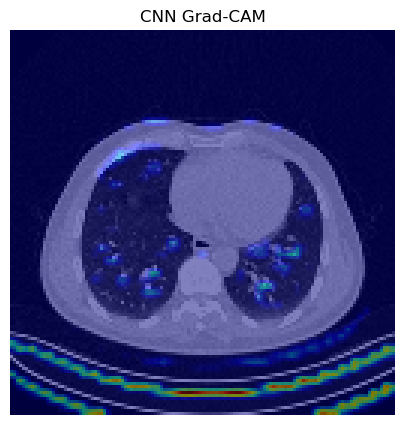

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 60ms/step


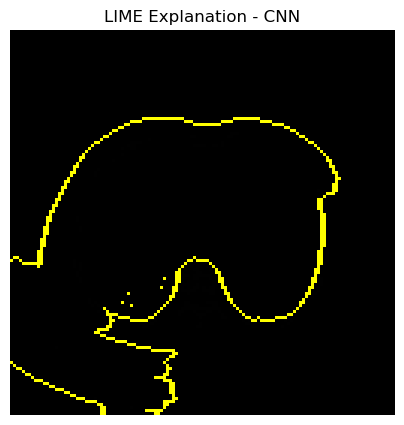

CNN SHAP Explanation:


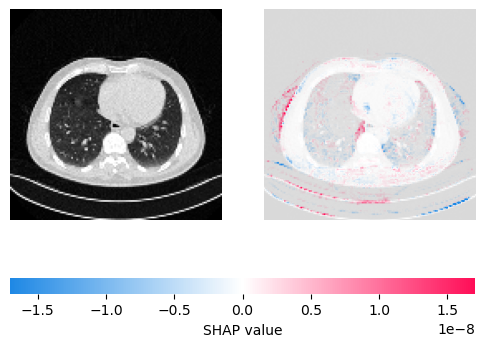

In [45]:
print("===== CNN Explainability =====")
gradcam(cnn_model, sample_image, "CNN")
lime_explanation(cnn_model, sample_image, "CNN")
shap_explanation(cnn_model, x_val[:10], "CNN")

===== RNN Explainability =====


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


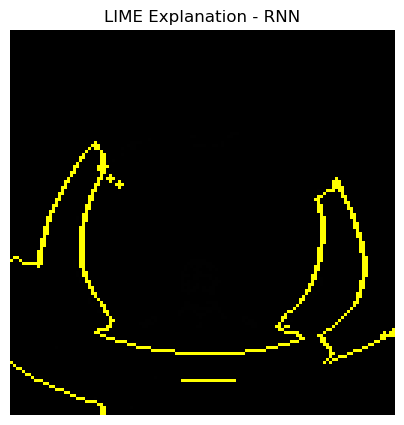

In [46]:
print("===== RNN Explainability =====")
lime_explanation(rnn_model, sample_image, "RNN")

===== ANN Explainability =====


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


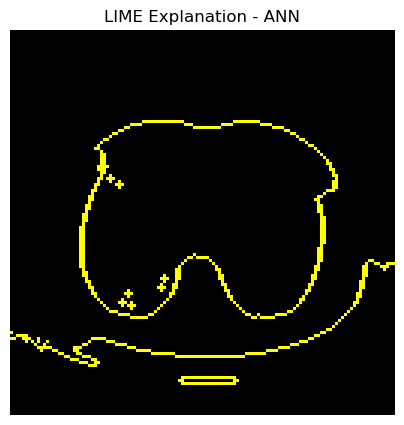

ANN SHAP Explanation:


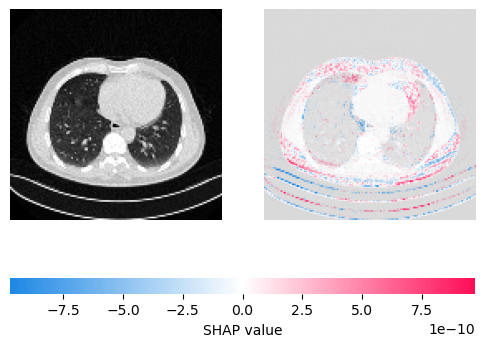

In [47]:
print("===== ANN Explainability =====")
lime_explanation(ann_model, sample_image, "ANN")
shap_explanation(ann_model, x_val[:10], "ANN")

In [48]:
def evaluate_model(model, x_data, y_data, name):
    y_pred = model.predict(x_data)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_data, axis=1)

    print(f"\n{name} Model Evaluation:")
    print(confusion_matrix(y_true_classes, y_pred_classes))
    print(classification_report(y_true_classes, y_pred_classes, target_names=categories))

evaluate_model(cnn_model, x_val, y_val, "CNN")
evaluate_model(rnn_model, x_val, y_val, "RNN")
evaluate_model(ann_model, x_val, y_val, "ANN")

7/7 [==============================] - 1s 75ms/step

CNN Model Evaluation:
[[ 83   0   0]
 [  2  22   0]
 [  0   0 113]]
                 precision    recall  f1-score   support

   Normal cases       0.98      1.00      0.99        83
   Bengin cases       1.00      0.92      0.96        24
Malignant cases       1.00      1.00      1.00       113

       accuracy                           0.99       220
      macro avg       0.99      0.97      0.98       220
   weighted avg       0.99      0.99      0.99       220

7/7 [==============================] - 0s 19ms/step

RNN Model Evaluation:
[[ 83   0   0]
 [  3  21   0]
 [  1   1 111]]
                 precision    recall  f1-score   support

   Normal cases       0.95      1.00      0.98        83
   Bengin cases       0.95      0.88      0.91        24
Malignant cases       1.00      0.98      0.99       113

       accuracy                           0.98       220
      macro avg       0.97      0.95      0.96       220
   weighted 

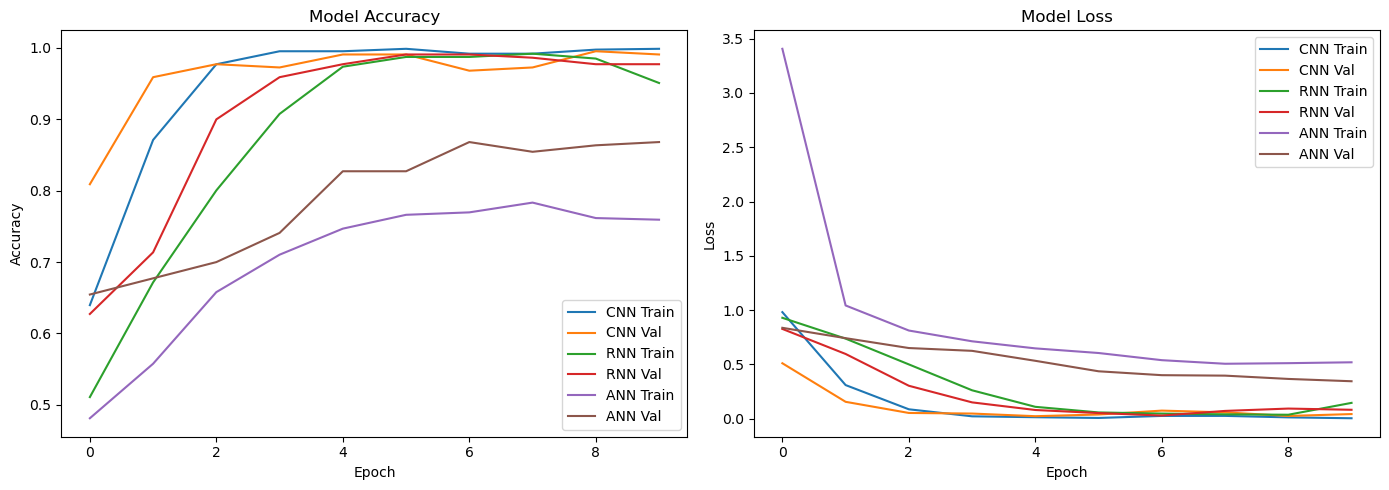

In [49]:
def plot_performance(histories, labels):
    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(history.history['accuracy'], label=f'{label} Train')
        plt.plot(history.history['val_accuracy'], label=f'{label} Val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(history.history['loss'], label=f'{label} Train')
        plt.plot(history.history['val_loss'], label=f'{label} Val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_performance([cnn_history, rnn_history, ann_history], ['CNN', 'RNN', 'ANN'])